## Main Idea

We make use of Variational Inference to approximate the "true" posterior of the latent space $p(z|x)$ with an auxiliary distribution $q(z|x)$ by minimizing the KL Divergence between these two distribution:
$$ D_{KL}(q(z|x)||p(z|x)) = \sum q(z|x) \log \frac{q(z|x)}{p(z|x)} $$

We use a neural network to parameterize $q(z|x)$ such that we can minimize the $D_{KL}$ by training the network. $q(z|x)$ becomes our encoder that outputs the parameter $\theta$ of our distribution $q(z|x) = q_{\theta}(z|x)$. 

Recap the posterior is defined as (Bayes´ Rule):

$$
p(z|x) = \frac{Likelihood * Prior}{Marginal Distribution}=\frac{p(x|z)p(z)}{p(x)}
$$

## ELBO Loss

We can derive the ELBO Loss from $D_{KL}(q(z|x)||p(z|x))$ which will be our overall loss function for our VAE:
\begin{align}
D_{KL}(q(z|x)||p(z|x)) &= \sum q(z|x) \log \frac{q(z|x)}{p(z|x)}\\
&= -\sum q(z|x) \log \frac{p(z|x)}{q(z|x)}\\
&= -\sum q(z|x)  \left[\log p(z|x) - \log q(z|x) \right]\\
&= -\sum q(z|x) \left[\log \frac{p(x|z)p(z)}{p(x)} - \log q(z|x) \right]\\
&= -\sum q(z|x) \left[\log p(x|z) + \log p(z) - \log p(x) - \log q(z|x) \right]\\
&= \sum q(z|x) \left[-\log p(x|z) - \log p(z) + \log p(x) + \log q(z|x) \right]\\
D_{KL}(q(z|x)||p(z|x)) - \sum q(z|x) \left[-\log p(x|z) - \log p(z) + \log q(z|x) \right] &= \log p(x)\\
-\sum q(z|x) \left[-\log p(x|z) + \log \frac{q(z|x)}{p(z)} \right] &= \\
-\mathbb{E}_{z \sim q(z|x)} \left[-\log p(x|z) + \log \frac{q(z|x)}{p(z)} \right] &=\\
-\mathbb{E}_{q} \left[-\log p(x|z) + \log \frac{q(z|x)}{p(z)} \right] &=\\
\mathbb{E}_{q} \left[\log p(x|z) - \log \frac{q(z|x)}{p(z)} \right] &=\\
D_{KL}(q(z|x)||p(z|x)) + \left[ \mathbb{E}_{q} \log p(x|z)  - \mathbb{E}_{q}  \log \frac{q(z|x)}{p(z)} \right] &= \log p(x)\\
D_{KL}(q(z|x)||p(z|x)) + Variational Lower Bound (ELBO) &= \log p(x) \\
ELBO &= \log p(x) - D_{KL}(q(z|x)||p(z|x)) \\
\left[ \mathbb{E}_{q} \log p(x|z)  - \mathbb{E}_{q}  \log \frac{q(z|x)}{p(z)} \right] &= \log p(x) - D_{KL}(q(z|x)||p(z|x)) \\
\left[ \mathbb{E}_{q} \log p(x|z)  - \mathbb{E}_{q}[ \log q(z|x) - \log p(z)] \right] &= \log p(x) - D_{KL}(q(z|x)||p(z|x)) \\
\left[ \mathbb{E}_{q} \log p(x|z)  - D_{KL}(q(x|z)||p(z)) \right] &= \log p(x) - D_{KL}(q(z|x)||p(z|x))   \leq \log p(x) \\
\end{align}

So if we maximize ELBO this corresponding to maximizing the log probability of generating real data samples $\log p(x)$ (lower bound) which is reduced by the divergence of our "true" and approximate distribution. Maximizing ELBO is same as minizing the negative ELBO:
$$\mathcal{L} = max(ELBO) = max \left( \mathbb{E}_{q} \log p(x|z)  - D_{KL}(q(x|z)||p(z)) \right) 
             = min(-ELBO) = min \left(D_{KL}(q(x|z)||p(z)) - \mathbb{E}_{q} \log p(x|z) \right)  $$

### Reconstruction Loss: $- \mathbb{E}_{q} \log p(x|z)$

The probability of our image (each pixel to be precise) given we observed latent variable $z$ (sampled from $q$). We obtain this multidimensional probability distribution from the reconstructed $\hat{x}$ of our probabilistic decoder. In terms of Gaussians, $\hat{x}$ will be our mean for each dimension while we assume standard deviation of 1. This term will get larger the closer the mean of the distribution approaches the original image, miniziming the overall ELBO loss.  $- \mathbb{E}_{q}$ here refers to $z$ being sampled from $q$, this is the Monte Carlo Estimate of the loss, getting more precise to the analytical results with higher batch sizes (Law of large numbers), this [post](https://towardsdatascience.com/variational-autoencoder-demystified-with-pytorch-implementation-3a06bee395ed) recommend a batch size of 128 throughout the training.



In [127]:
import torch
from torch.nn import functional as F

def reconstruction_loss(x_hat, x, logscale):
    """
    Monte Carlo Reconstruction Loss
    """
    scale = torch.exp(logscale) # sigma is e^0 = 1
    mean = x_hat
    #construct p(x|z) given decoded mean parameter x_hat and sigma = 1 for all dim. of x_hat
    dist = torch.distributions.Normal(mean, scale)
    #return log probability of original x of newly constructed distribution
    return dist.log_prob(x).sum(dim=(1,2,3))

def reconstruction_loss_mse(x_hat, x):
    """
    MSE reconstruction loss for (e.g MNIST)
    """
    return torch.mean(torch.nn.MSELoss(x_hat, x))

def reconstruction_loss_bce(x_hat, x):
    """
    BCE reconstruction loss for (e.g. MNIST) requires Sigmoid output of Decoder (x_hat)
    """
    return torch.mean(- F.binary_cross_entropy(x_hat, x, reduce='sum'))


### KL Divergence Loss: $D_{KL}(q(x|z)||p(z)) = \mathbb{E}_{q}[ \log q(z|x) - \log p(z)]$

This is the term, we want to minimize in order to maximize the ELBO (not to be confused with the ELBO loss). It defines the expected log difference between our prior latent distribution $p(z)$ and our posterior approximated by $q(x|z)$. Again we use the Monte Carlo approximation of the divergence such that we sample from $q$. 

Additionally, Kingma and Welling (2022) have shown that (only!) for two Gaussians $q$ and $p$ and latent dimensionality $J$, $D_{KL}$ simplifies to
$$ D_{KL}(q_{\phi}(z)||p_{\theta}(z)) = - \int q_{\theta}(x|z) (\log p_{\theta}(z) - q_{\theta}(z)) dz = - \frac{1}{2} \sum^{J}_{j=1}(1 + \log((\sigma_{j})^2)) - (\mu_{j})^2 -(\sigma_{j})^2)$$

$\sigma$ and $\mu$ are then just functions of $x$ when using $q_{\phi}(x|z)$ and resemble the parameters $\phi$.

In [128]:
def kl_divergence(z, mu, std):
    """
    Monte Carlo KL Divergence (precision to analytical KLD depends on batch size of z)
    """
    # Standard Gaussian as target distribution p(z)
    p = torch.distributions.Normal(torch.zeros_like(mu), torch.ones_like(std))
    # Auxiliary approximate distribution q(x|z)
    q = torch.distributions.Normal(mu, std)
    
    
    # KL Divergence according to our ELBO derivation
    kl = (q.log_prob(z) - p.log_prob(z))
    
    # trick to sum over all dimensions
    return kl.sum(-1)

def kl_divergence_gaussian(mu, std):
    """
    KL Divergence simplified for Gaussian as per Kingma and Welling (2022)
    """
    return torch.mean(- 0.5 * torch.sum(1 + std ** 2 - mu ** 2 - std ** 2, dim = 1), dim = 0)

# VAE Model and Pytorch Lightning Implementation

VAE CNN Model

In [129]:
import pytorch_lightning as pl
import torch
from torch import nn
from torch.nn import functional as F
from pl_bolts.models.autoencoders.components import (
    resnet18_decoder,
    resnet18_encoder,
)


class VAE(pl.LightningModule):
    """
    VAE model
    """
    
    def __init__(self, enc_out_dim = 512, latent_dim = 256, input_height = 32, input_channels = 3):
        
        super().__init__()
        
        self.save_hyperparameters()

        #scale any input to 3 channels
        self.channel_layer = nn.Conv2d(in_channels=input_channels, out_channels=3, kernel_size=1, padding='same')

        # encoder q(z|x) => output: distribution param
        self.encoder = resnet18_encoder(False, False)
        
        #decoder p(x|z) => output: sample from high-dim. distribution of input image shape
        self.decoder = resnet18_decoder(
            latent_dim=latent_dim, 
            input_height=input_height, 
            first_conv=False, 
            maxpool1=False
        )

        # latent distribution parameters
        self.fc_mu = nn.Linear(enc_out_dim, latent_dim)
        self.fc_var = nn.Linear(enc_out_dim, latent_dim)
        
        # for the gaussian likelihood
        self.log_scale = nn.Parameter(torch.Tensor([0.0]))
               
    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=3e-4)
    

    def training_step(self, batch, batch_idx):
        x, _ = batch

        print(f" Min pixel value: {torch.min(x)}, max pixel value: {torch.max(x)}")

        # adjust channel dimension to 3
        x_channel_adjusted = self.channel_layer(x)

        # encode x to get the mu and variance parameters
        x_encoded = self.encoder(x_channel_adjusted)
        mu, log_var = self.fc_mu(x_encoded), self.fc_var(x_encoded)

        # sample z from q with reparameterization trick
        std = torch.exp(log_var / 2)
        q = torch.distributions.Normal(mu, std)
        z = q.rsample()

        # decoded (x_hat are )
        x_hat = self.decoder(z)

        # reconstruction loss
        recon_loss = reconstruction_loss(x_hat, x, self.log_scale)

        # kl divergence
        kl = kl_divergence(z, mu, std)

        # elbo loss
        elbo = (kl - recon_loss)
        elbo = elbo.mean()

        self.log_dict({
            'elbo': elbo,
            'kl': kl.mean(),
            'recon_loss': recon_loss.mean(), 
            'reconstruction': recon_loss.mean(),
        }, on_epoch=True)

        return elbo

VAE MLP Model 

Based on https://github.com/dragen1860/pytorch-mnist-vae/blob/master/run_main.py

In [130]:
from torch.nn import functional as F

class MNIST_VAE(pl.LightningModule):

    def __init__(self, enc_out_dim = 40, latent_dim = 20, input_height = 32, sigmoid = False):
        
        super().__init__()


        self.n_hidden = 500
        self.drop_out_prob = 1 - 0.99
        self.sigmoid = sigmoid
        self.save_hyperparameters()
        
        # for the gaussian likelihood
        self.log_scale = nn.Parameter(torch.Tensor([0.0]))

        # encoder q(z|x) => output: distribution param
        self.encoder = nn.Sequential(
            #first layer
            nn.Linear(input_height ** 2, self.n_hidden),
            nn.ELU(inplace=True),
            nn.Dropout(self.drop_out_prob),
            #second layer
            nn.Linear(self.n_hidden, self.n_hidden),
            nn.Tanh(),
            nn.Dropout(self.drop_out_prob),
            nn.Linear(self.n_hidden, enc_out_dim)
        )

        self.fc_mu = nn.Linear(enc_out_dim, latent_dim)
        #softplus to ensure only positive var/std_dev
        self.fc_var = nn.Linear(enc_out_dim, latent_dim)
        
        #decoder p(x|z) => output: sample from high-dim. distribution of input image shape
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, self.n_hidden),
            nn.Tanh(),
            nn.Dropout(self.drop_out_prob),
            nn.Linear(self.n_hidden, self.n_hidden),
            nn.ELU(),
            nn.Dropout(self.drop_out_prob),
            nn.Linear(self.n_hidden, input_height ** 2),
            # nn.Sigmoid() #for binary cross entropy
        )

        if self.sigmoid:
            self.sigmoid = nn.Sigmoid()
               
    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=1e-3)
    
    def reconstruction_loss(self, x_hat, x, logscale):
        """
        Monte Carlo Reconstruction Loss
        """
        scale = torch.exp(logscale) # sigma is e^0 = 1
        mean = x_hat
        #construct p(x|z) given decoded mean parameter x_hat and sigma = 1 for all dim. of x_hat
        dist = torch.distributions.Normal(mean, scale)
        #return log probability of original x of newly constructed distribution
        return torch.sum(dist.log_prob(x), dim=(1,))

    def training_step(self, batch, batch_idx):
        x, _ = batch

        #print(f"Pixel range: [{torch.min(x)}:{torch.max(x)}]")
        
        x = torch.flatten(x[:,0,:,:], 1)

        # encode x to get the mu and variance parameters
        x_encoded = self.encoder(x)
        
        mu, log_var = self.fc_mu(x_encoded), self.fc_var(x_encoded)
        log_var = 1e-6 + F.softplus(log_var)
        # sample z from q with reparameterization trick
        std = torch.exp(log_var/2) # maybe /2
        q = torch.distributions.Normal(mu, std)
        z = q.rsample()

        # decoded (x_hat are parameter of )
        x_hat = self.decoder(z)

        if self.sigmoid:
            x_hat = nn.Sigmoid(x_hat)

        # reconstruction loss
        recon_loss = self.reconstruction_loss(x_hat, x, self.log_scale)
        # kl divergence
        kl = kl_divergence(z, mu, std)

        # elbo loss
        elbo = (kl - recon_loss)
        elbo = elbo.mean()

        self.log_dict({
            'elbo': elbo,
            'kl': kl.mean(),
            'recon_loss': recon_loss.mean(), 
            'reconstruction': recon_loss.mean(),
        }, on_epoch=True)

        return elbo



In [131]:
from pytorch_lightning.callbacks import Callback

class VAEMetricTracker(Callback):

    def __init__(self):
        self.metrics_dict_logs = []

    def on_validation_epoch_end(self, trainer):
        elogs = trainer.logged_metrics
        self.metrics_dict_logs.append(elogs)


Creating a Dataloader for the pokemon image dataset. Optionally also also for the MNIST dataset.

In [132]:
import torchvision.datasets as dset
import torchvision.transforms as transforms

# Root directory for dataset
dataroot = "data/pokemon"

# Batch size during training
batch_size = 24

# Spatial size of training images. All images will be resized to this
#   size using a transformer.
image_size = 28

# Create the dataset
dataset = dset.ImageFolder(root=dataroot,
                           transform=transforms.Compose([
                               transforms.Resize(image_size),
                               transforms.CenterCrop(image_size),
                               transforms.ToTensor(),
                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                           ]))
# Create the dataloader
pokemon_dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                         shuffle=True, num_workers=2)


from torchvision.datasets import MNIST
from torchvision import transforms
import os

PATH_DATASETS = os.environ.get("PATH_DATASETS", ".")
# Init DataLoader from MNIST Dataset
mnist_ds = MNIST(PATH_DATASETS, train=True, download=True, transform=transforms.Compose([
                               transforms.Resize(image_size),
                               transforms.CenterCrop(image_size),
                               transforms.ToTensor(),
                           ]))
mnist_loader = torch.utils.data.DataLoader(mnist_ds, batch_size=128, shuffle=True, num_workers=16)

In [134]:
from pytorch_lightning.callbacks import ModelSummary
from pytorch_lightning.callbacks.early_stopping import EarlyStopping
import torch

#clear gpu cache
torch.cuda.empty_cache()

pl.seed_everything(1234)
torch.set_float32_matmul_precision('high')

metric_tracker = VAEMetricTracker()

#vae = VAE(input_height = image_size, input_channels=1, latent_dim=256)

vae = MNIST_VAE(input_height=image_size, enc_out_dim=64, latent_dim=40)
trainer = pl.Trainer(devices=1, accelerator="gpu", max_epochs=100, callbacks=[metric_tracker, 
                                                                            EarlyStopping(monitor="elbo", check_on_train_epoch_end=True, mode='min')])

#with warnings.catch_warnings('ignore')
trainer.fit(vae, mnist_loader)

Global seed set to 1234
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type       | Params
---------------------------------------
0 | encoder | Sequential | 675 K 
1 | fc_mu   | Linear     | 2.6 K 
2 | fc_var  | Linear     | 2.6 K 
3 | decoder | Sequential | 663 K 
---------------------------------------
1.3 M     Trainable params
0         Non-trainable params
1.3 M     Total params
5.376     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=100` reached.


Generating and Plotting some images with trained VAE.

<Figure size 2400x900 with 0 Axes>

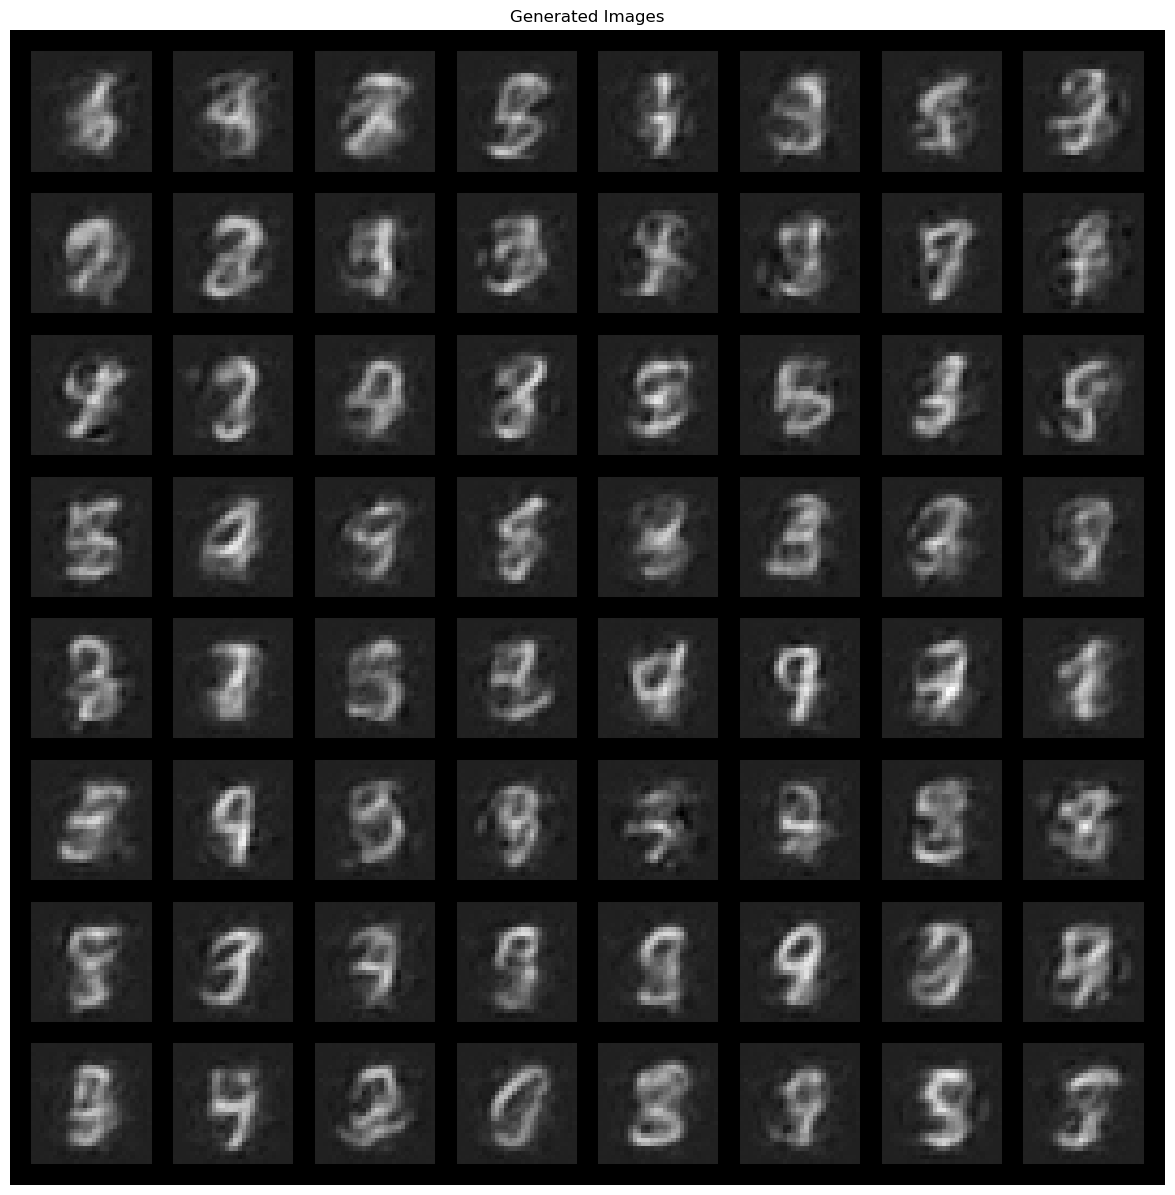

In [135]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow, figure
import numpy as np
from torchvision.utils import make_grid
figure(figsize=(8, 3), dpi=300)

# sample latent vector z from multivariant standard gaussian (same distribibution assumed for q/p in training)
num_preds = 64
pl_module = vae
rand_v = torch.rand((num_preds, pl_module.hparams.latent_dim), device=pl_module.device)
p = torch.distributions.Normal(torch.zeros_like(rand_v), torch.ones_like(rand_v))
z = p.rsample()

# generate image given z from VAE decoder
with torch.no_grad():
    pred = vae.decoder(z.to(vae.device)).cpu()
    pred = torch.reshape(pred, (pred.size(0), image_size, image_size))
    pred = pred[:,None,:,:]
    
plt.figure(figsize=(15,15))
img = make_grid(pred, padding=5, normalize=True).permute(1, 2, 0).numpy()
plt.title("Generated Images")
plt.axis("off")
plt.imshow(img)
plt.show()

T-SNE Plot of some of the test classes to visualize final latent space.

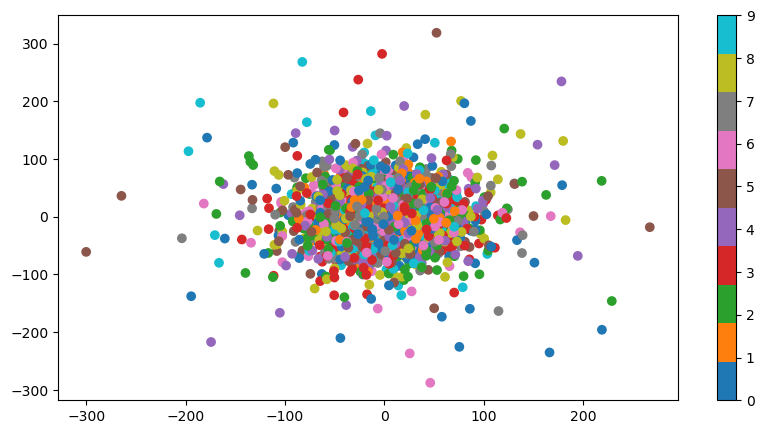

In [136]:
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import warnings 

# Init DataLoader from MNIST Dataset
dataset = MNIST(PATH_DATASETS, train=False, download=True, transform=transforms.Compose([
                               transforms.Resize(image_size),
                               transforms.CenterCrop(image_size),
                               transforms.ToTensor(),
                               transforms.Normalize((0.5), (0.5)),
                           ]))
dataloader = torch.utils.data.DataLoader(dataset, batch_size=64, shuffle=False, num_workers=10)

def plot_latent(vae, dataloader, num_batches=50):
    plt.figure(figsize=(10,5))
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        for i, (samples, labels) in enumerate(dataloader):
            # adjust to 3 channels
            # samples = vae.channel_layer(samples.to(vae.device))
            # encode
            samples = torch.flatten(samples[:,0,:,:], 1)
            x_encoded = vae.encoder(samples.to(vae.device))
            # get param of multivariant gaussian
            mu, log_var = vae.fc_mu(x_encoded), vae.fc_var(x_encoded)
            log_var = 1e-6 + F.softplus(log_var/2)
            std = torch.exp(log_var)            
            q = torch.distributions.Normal(mu, std)
            # sample z from Gaussian (q)
            z = q.rsample().detach().numpy()
            reduced_dim = TSNE(n_components=2).fit_transform(z)
            plt.scatter(reduced_dim[:,0], reduced_dim[:,1], c=labels, cmap='tab10')
            if i > num_batches:
                plt.colorbar()
                plt.show()
                break

plot_latent(vae, dataloader)